## Example workflow notebook

This notebook shows how to use the classes and functions provided by the `epicluster` package to run MCMC inference.

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.stats
import pandas as pd
import epicluster as ec

In [2]:
random.seed(100)
np.random.seed(100)

Functions to generate synthetic case series.

In [3]:
def poisson_rvs(mu):
    return scipy.stats.poisson.rvs(mu)

def negativebinomial_rvs(mu, kappa, n=1):
    n1 = kappa
    p = float(kappa) / (kappa + mu)
    return scipy.stats.nbinom.rvs(n1, p, 0, n)

def expected_cases(Rt, past_cases, serial_interval):
    if np.abs(sum(serial_interval) - 1) > 1e-6:
        raise ValueError("Serial interval does not sum to 1.")
    return Rt * np.dot(past_cases, serial_interval)

def next_cases(Rt, past_cases, serial_interval, kappa):
    expectation = expected_cases(Rt, past_cases, serial_interval)
    if kappa is not None:
        return negativebinomial_rvs(expectation, kappa)
    else:
        return poisson_rvs(expectation)

def generate_case_series(Rt_series, past_cases, serial_interval, kappa=None):
    n_past_cases = len(past_cases)
    if n_past_cases != len(serial_interval):
        raise ValueError("Past cases must be of same length as serial interval.")
    series_len = len(Rt_series)
    cases = np.zeros(series_len + n_past_cases)
    cases[:n_past_cases] = past_cases
    for i in range(series_len):
        new_case_index = i + n_past_cases
        historical_cases = cases[i:new_case_index]
        historical_cases_rev = historical_cases[::-1]
        cases[new_case_index] = next_cases(
            Rt_series[i], historical_cases_rev, serial_interval, kappa)
    cases_post_past = cases[n_past_cases:]
    days = np.arange(1, len(cases_post_past) + 1)
    df = pd.DataFrame(
        {'day': days,
        'cases': cases_post_past,
        'Rt': Rt_series})
    return df

Generate synthetic case series.

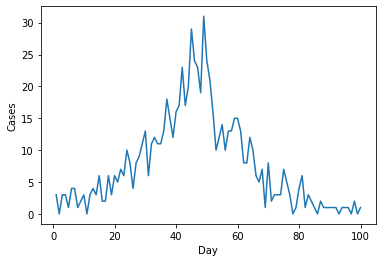

In [4]:
# Use a gamma(2, 0.5) serial interval, which is obtained by discretising a continuous distribution.
tmax = 20
w_int = [scipy.stats.gamma.cdf(x, 2, scale=2) for x in range(tmax)]
w = np.diff(w_int)
serial_interval = w / sum(w)

# pad with cases prior to t=0
past_cases = np.zeros(len(w))
past_cases[-1] = 5
past_cases[-2] = 5
past_cases[-3] = 5

# split Rt series into two segments
Rt_part_1 = np.repeat(1.3, 50)
Rt_part_2 = np.repeat(0.8, 50)
Rt_series = np.concatenate([Rt_part_1, Rt_part_2])

# generate cases
cases_df = generate_case_series(Rt_series, past_cases, serial_interval)
cases = cases_df['cases']

# plot cases
plt.plot(cases_df["day"], cases_df["cases"])
plt.xlabel("Day")
plt.ylabel("Cases")
plt.show()

Run inference using 4 MCMC chains.

In [5]:
model = ec.PoissonModel(np.concatenate((past_cases, cases)), serial_interval)
n_chains = 4
posterior = ec.MCMCSampler(model, n_chains)
params, assignments, sizes = posterior.run_mcmc(Rhat_thresh=1.1, progress=True)

Iter=50, Rhat=29.864354718341744
Iter=100, Rhat=10.211902157140138
Iter=150, Rhat=4.219810732127684
Iter=200, Rhat=2.4435943584856363
Iter=250, Rhat=1.269060477122429
Iter=300, Rhat=1.050893307334828
Converged 300 1.050893307334828


Extract the Rt value over time for each MCMC sample.

In [6]:
R_profiles = []
for R, z in zip(params, assignments):
    R_profiles.append([R[zi] for zi in z])
num_mcmc_samples = len(R_profiles)

Plot the draws of Rt profiles (only for the second half of the MCMC chain), their mean and the true Rt series.

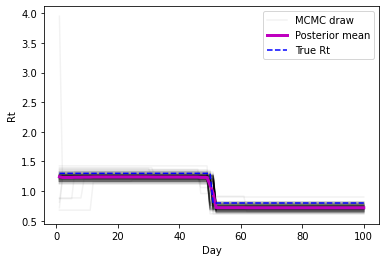

In [7]:
for i in range(num_mcmc_samples//2, num_mcmc_samples):
    plt.plot(cases_df["day"],
             R_profiles[i],
             'k',
             alpha=0.05,
             label='MCMC draw' if i==num_mcmc_samples//2 else None)
    
plt.plot(cases_df["day"], np.mean(R_profiles[num_mcmc_samples//2:], axis=0), 'm', lw=3, label='Posterior mean')
plt.plot(cases_df["day"], cases_df["Rt"], 'b--', label='True Rt')

plt.legend()
plt.xlabel("Day")
plt.ylabel("Rt")
plt.show()